In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch, sys, subprocess, os, platform
from PIL import Image
import matplotlib.pyplot as plt
import glob, os, pathlib
import re, io
from google.colab import files
import os, json

!pip -q install git+https://github.com/openai/CLIP.git ftfy regex tqdm imageio-ffmpeg opencv-python

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
PROMPT_TXT = f"/content/drive/MyDrive/colab_shared/style_prompts/prompt_1755856272_079be1c0.txt"
PROMPT_JSON = f"/content/drive/MyDrive/colab_shared/style_prompts/prompt_1755856272_079be1c0.json"

In [ ]:
prompt = None
if os.path.exists(PROMPT_TXT):
    with open(PROMPT_TXT, "r") as f:
        prompt = f.read().strip()
elif os.path.exists(PROMPT_JSON):
    with open(PROMPT_JSON, "r") as f:
        data = json.load(f)
        prompt = data.get("final_prompt")

assert prompt, "No prompt found. Set PROMPT_TXT or PROMPT_JSON correctly."
print("Using prompt:", prompt)

Using prompt: cinematic, city, brooklyn, bridge, water, strong, timeless, skyline, bright, sky, heart, world, alive


In [ ]:
PROJECT_DIR = "/content/clipstyler_local"
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)

In [ ]:
path = "train_CLIPstyler.py"
# https://github.com/cyclomon/CLIPstyler
# sampler.py, predict.py, function.py, template.py, utils.py, StyleNet.py, train_CLIPstyler.py 사용
with open(path, "r", encoding="utf-8") as f:
    src = f.read()

patched = re.sub(
    r"\bdevice\s*=\s*['\"]cuda['\"]",
    "device = 'cuda' if torch.cuda.is_available() else 'cpu'",
    src
)

if patched != src:
    with open(path, "w", encoding="utf-8") as f:
        f.write(patched)
    print("train_CLIPstyler.py: device 고정값을 안전하게 수정했습니다.")
else:
    print("패치할 필요가 없었습니다(이미 안전).")

train_CLIPstyler.py: device 고정값을 안전하게 수정했습니다.


In [ ]:
CONTENT_DIR = "/content/content_images"
os.makedirs(CONTENT_DIR, exist_ok=True)

In [ ]:
print("스타일 변환할 content 이미지를 업로드하세요 (jpg/png).")
uploaded_imgs = files.upload()
for name, data in uploaded_imgs.items():
    with open(os.path.join(CONTENT_DIR, name), "wb") as f:
        f.write(data)

content_path = sorted(glob.glob(f"{CONTENT_DIR}/*"))[0]  # 첫 번째 이미지 사용
content_name = pathlib.Path(content_path).stem
print("CONTENT =", content_path)

스타일 변환할 content 이미지를 업로드하세요 (jpg/png).


Saving KakaoTalk_20250821_174613242_03.jpg to KakaoTalk_20250821_174613242_03.jpg
CONTENT = /content/content_images/KakaoTalk_20250821_174613242_03.jpg


In [ ]:
os.chdir("/content/clipstyler_local")
print("CWD:", os.getcwd())

os.makedirs("outputs", exist_ok=True)

CWD: /content/clipstyler_local


In [ ]:
PROMPT = prompt
EXP    = "exp_colab_1"

!python -u train_CLIPstyler.py \
  --content_path "{content_path}" \
  --content_name "{content_name}" \
  --exp_name "{EXP}" \
  --text "{PROMPT}" \
  --max_step 200 --lr 5e-4 --num_crops 64 --crop_size 128

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more de

생성된 파일 수: 1
Show: outputs/cinematic, city, brooklyn, bridge, water, strong, timeless, skyline, bright, sky, heart, world, alive_KakaoTalk_20250821_174613242_03_exp_colab_1.jpg


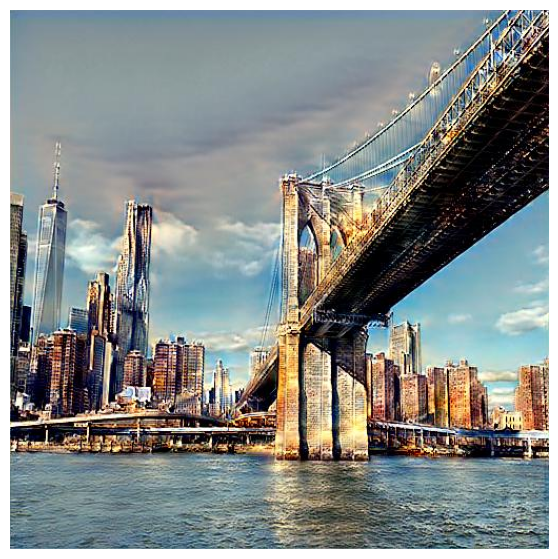

In [ ]:
cands = sorted(glob.glob("outputs/*"), key=os.path.getmtime)
print("생성된 파일 수:", len(cands))
if cands:
    img_path = cands[-1]
    print("Show:", img_path)
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(7,7)); plt.axis("off"); plt.imshow(img)
else:
    print("출력 파일이 보이지 않으면, 스크립트의 저장 경로와 파일명을 확인하세요.")